In [2]:
library(GenomicRanges)
library(rtracklayer)
library(GPosExperiment)
library(AnVIL)
library(fitdistrplus)
library(tidyverse)
library(kableExtra)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixS

In [3]:
gene_fn <- "genelist.gff"

gc_project <- gcloud_project()
current_workspace <- avworkspace()
print(str_glue("project={gc_project}, workspace={current_workspace}"))

project=terra-d39d2a2c, workspace=broad-cpa-pipeline/netseq-2022-03-b


In [4]:
set.seed(20220311)

matrix_apply <- function(x, f, ...) {
  result <- sapply(x, f, ...)
  dim(result) <- dim(x)
  dimnames(result) <- dimnames(x)
  result
}

workdir <- tempdir()
gene_path <- file.path(workdir, gene_fn)

In [5]:
gene_path
avfiles_restore(source = gene_fn, destination = workdir)
which <- import(gene_path, genome = "sacCer3")
# TODO report number of genes
# TODO extract subset

[1] "/tmp/RtmpycAUEK/genelist.gff"

Copying gs://fc-secure-5818fb38-baa7-40ff-b964-df05e0b8b0bd/genelist.gff...
/ [1/1 files][  3.2 MiB/  3.2 MiB] 100% Done                                    
Operation completed over 1 objects/3.2 MiB.                                      

In [6]:
gcloud_account()
gcloud_project() # billing project information
avbucket()

[1] "pet-110371272146592282187@terra-d39d2a2c.iam.gserviceaccount.com"

[1] "terra-d39d2a2c"

[1] "gs://fc-secure-5818fb38-baa7-40ff-b964-df05e0b8b0bd"

In [7]:
qsam <- avtable(table = "qsample") %>% filter(!is.na(output_bam))

In [37]:
flist <- qsam[, c("mask_pos", "mask_neg", "bedgraph_pos", "bedgraph_neg")]
localList <- as_tibble(matrix_apply(flist, function(u) file.path(workdir,basename(u)))) # HACK use dplyr

for (fn in unlist(flist)) {
    cmd <- str_glue("alpha storage cp {fn} {workdir}/")
    print(cmd)
    gcloud_cmd(cmd)
}


alpha storage cp gs://fc-secure-5818fb38-baa7-40ff-b964-df05e0b8b0bd/345ea89b-a274-4b45-8e79-bda907e0db4b/netseq/4320d2d1-177d-4628-a440-2af13187e949/call-AlignReads/set2-1.mask_pos.bedgraph.gz /tmp/RtmpycAUEK/
alpha storage cp gs://fc-secure-5818fb38-baa7-40ff-b964-df05e0b8b0bd/345ea89b-a274-4b45-8e79-bda907e0db4b/netseq/e6326931-e794-4341-94d8-71b179d76d30/call-AlignReads/set2-2.mask_pos.bedgraph.gz /tmp/RtmpycAUEK/
alpha storage cp gs://fc-secure-5818fb38-baa7-40ff-b964-df05e0b8b0bd/345ea89b-a274-4b45-8e79-bda907e0db4b/netseq/4320d2d1-177d-4628-a440-2af13187e949/call-AlignReads/set2-1.mask_neg.bedgraph.gz /tmp/RtmpycAUEK/
alpha storage cp gs://fc-secure-5818fb38-baa7-40ff-b964-df05e0b8b0bd/345ea89b-a274-4b45-8e79-bda907e0db4b/netseq/e6326931-e794-4341-94d8-71b179d76d30/call-AlignReads/set2-2.mask_neg.bedgraph.gz /tmp/RtmpycAUEK/
alpha storage cp gs://fc-secure-5818fb38-baa7-40ff-b964-df05e0b8b0bd/345ea89b-a274-4b45-8e79-bda907e0db4b/netseq/4320d2d1-177d-4628-a440-2af13187e949/call-A

In [45]:
# TODO Report the samples
nsd <- NETseqDataFromBedgraph(qsam$qsample_id,
                            localList$bedgraph_pos, localList$bedgraph_neg,
                            seqinfo = seqinfo(which))

In [49]:
# TODO need "which" parameter for GPosExperiment
# TODO add masks to the constructor
for (i in seq_along(nsd)) {
  m1 <- import(localList$mask_pos[i])
  m2 <- import(localList$mask_neg[i])
  strand(m1) <- "+"
  strand(m2) <- "-"
  mask(nsd[[i]]) <- sort(c(m1, m2))
}


In [51]:
e <- GPosExperiment(nsd, rowRanges = which)
s <- scores(e, apply_mask = TRUE, zero_fill = TRUE)
n_mask <- matrix_apply(s, function(u) sum(is.na(u$score)))

n_s <- matrix_apply(s, function(u) sum(u$score, na.rm = TRUE))

x.bar <- matrix_apply(s, function(u) mean(u$score, na.rm = TRUE))
assay(e, "x.bar") <- x.bar
prop.unmasked <- apply(GPosExperiment::mask(e), 2, function(u) sum(width(GRangesList(u))) / width(rowRanges(e)))
assay(e, "prop.unmasked") <- prop.unmasked


In [53]:
saveRDS(e, "~/GPosMasked.rds") #TODO parameterize file name ... do not use tmp or find a better way to delocalize

In [79]:
avfiles_backup("/home/jupyter/GPosMasked.rds")

Copying file:///home/jupyter/GPosMasked.rds [Content-Type=application/octet-stream]...
/ [1/1 files][ 21.2 MiB/ 21.2 MiB] 100% Done                                    
Operation completed over 1 objects/21.2 MiB.                                     

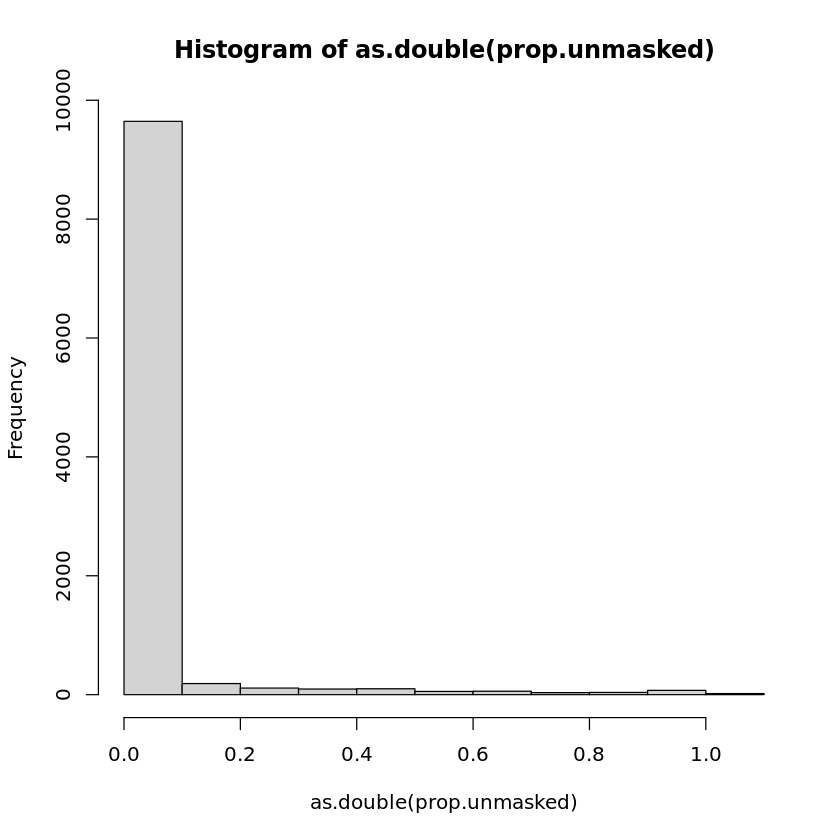

In [77]:
hist(as.double(prop.unmasked))

In [ ]:
cor(prop.unmasked)
mean(prop.unmasked == 0)

In [76]:
x <- prop.unmasked[, 1] - prop.unmasked[, 2]
xq <- round(quantile(x, seq(0, 1, .05)), 2)
t(xq)

0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,⋯,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
-0.66,-0.07,-0.04,-0.03,-0.03,-0.02,-0.02,-0.02,-0.01,-0.01,⋯,-0.01,0,0,0,0,0,0,0,0.01,0.31
